In [1]:
# Carrega as variáveis de embiente usadas pelo notebook. Estas variáveis devem ser criadas no arquivo .env, localizada no mesmo diretório do notebook
# As seguintes variáveis devem ser criadas:
# - export STR_CON=<string de conexão com o banco de dados relacional>
# - export RAW_DATA_PATH=<caminho onde os arquivos contendo o histórico de preço de cada ativo será armazenado>
# - export DATASET_PATH=<caminho onde os arquivos contendo o histórico de preço e os indicadores técnicos serão armazenados>
# - export MODELS_PATH=<caminnho onde os modelos treinados serão armazenados>
# - export TRAIN_DATASET=<caminho onde os datasets estandarizados e formatados para o treinamento serão armazenados>
%load_ext dotenv
%dotenv

# Garante que os scripts Python sejam recarregados em cada execução do notebook.
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from data_preparation import PreProcess

preprocess = PreProcess()
df_train = preprocess.read_dataset_from_parquet("data/train_dataset/ADX_14_EMA_20_AD/train_data.parquet")
df_test = preprocess.read_dataset_from_parquet("data/train_dataset/ADX_14_EMA_20_AD/test_data.parquet")

X_Train = np.array([val[0] for val in df_train.values])
X_Test = np.array([val[0] for val in df_test.values])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 50)                11200     
                                                                 
Total params: 11,200
Trainable params: 11,200
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector_4 (RepeatVect  (None, 50, 50)           0         
 or)                                                             
                                                                 
 lstm_15 (LSTM)              (None, 50, 50)            20200     
                                                                 
 time_distributed_4 (TimeDis  (None, 50, 5)            255       
 tributed)                

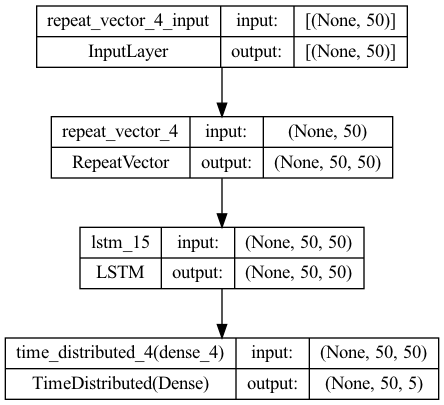

In [9]:
from keras.layers import Input, LSTM, RepeatVector, Dense, LeakyReLU, TimeDistributed
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model


# input_data = Input((X_Train.shape[1], X_Train.shape[2]) )
# Encoder
# layer = LSTM(100, input_shape=X_Train.shape)(input_data)
_encoder = Sequential([
    LSTM(50, input_shape=X_Train[0].shape)
])

_decoder = Sequential([
    RepeatVector(X_Train.shape[1]),
    LSTM(50, return_sequences=True),
    TimeDistributed(Dense(X_Train.shape[2]))])
# bridge = RepeatVector(X_Train.shape[1])(layer)

# # Decoder
# decoder = LSTM(100, input_shape=X_Train.shape, return_sequences=True)(bridge)
# decoder = TimeDistributed(Dense(X_Train.shape[2]))(decoder)

model = Sequential([_encoder, _decoder])
model.compile(optimizer='adam', loss='mse')

_encoder.summary()
_decoder.summary()
plot_model(_encoder, 'autoencoder_compress.png', show_shapes=True)
plot_model(_decoder, 'autoencoder_decompress.png', show_shapes=True)

In [10]:
batch_size = 32
epochs = 100

cp_early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               min_delta=0.001, 
                               mode='auto')
cp_model_checkpoint = ModelCheckpoint("data/tf_models/autoencoder/autoencoder.h5",
                                save_best_only=True)

model.fit(X_Train, X_Train, batch_size=batch_size, epochs=epochs, validation_data=(X_Test, X_Test), callbacks=[cp_early_stopping, cp_model_checkpoint])

Epoch 1/100


2022-10-16 22:30:42.594719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-16 22:30:43.012728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-16 22:30:43.201885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-16 22:30:43.671730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-16 22:30:43.959727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1788/1788 [==============================] - ETA: 0s - loss: 0.1971

2022-10-16 22:32:41.602644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-16 22:32:41.745666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-16 22:32:41.903034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1788/1788 [==============================] - 133s 72ms/step - loss: 0.1971 - val_loss: 0.1490
Epoch 2/100
1788/1788 [==============================] - 138s 77ms/step - loss: 0.1347 - val_loss: 0.1281
Epoch 3/100
1788/1788 [==============================] - 129s 72ms/step - loss: 0.1184 - val_loss: 0.1129
Epoch 4/100
1788/1788 [==============================] - 129s 72ms/step - loss: 0.1099 - val_loss: 0.1099
Epoch 5/100
1788/1788 [==============================] - 133s 75ms/step - loss: 0.1056 - val_loss: 0.1174
Epoch 6/100
1788/1788 [==============================] - 185s 103ms/step - loss: 0.1020 - val_loss: 0.1054
Epoch 7/100
1788/1788 [==============================] - 173s 97ms/step - loss: 0.0988 - val_loss: 0.1009
Epoch 8/100
1788/1788 [==============================] - 174s 97ms/step - loss: 0.0964 - val_loss: 0.0973
Epoch 9/100
1788/1788 [==============================] - 175s 98ms/step - loss: 0.0954 - val_loss: 0.0966
Epoch 10/100
1788/1788 [==============================] -

In [20]:
X_Test_repr = _encoder.predict(X_Test)
X_Train_repr = _encoder.predict(X_Train)
X_Train_repr.shape, X_Test_repr.shape

((57191, 50), (10198, 50))

In [24]:
from sklearn.linear_model import LogisticRegressionCV

logit = LogisticRegressionCV(cv=10, max_iter=500, n_jobs=-1)
logit.fit(X_Train_repr, df_train['label'].values)

LogisticRegressionCV(cv=10, max_iter=500, n_jobs=-1)

In [32]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

Y_test_predict = logit.predict(X_Test_repr)
print(accuracy_score(df_test['label'].values, Y_test_predict))
print(confusion_matrix(df_test['label'].values, Y_test_predict))
print(precision_score(df_test['label'].values, Y_test_predict))
print(recall_score(df_test['label'].values, Y_test_predict))
print(f1_score(df_test['label'].values, Y_test_predict))

0.6305157874092959
[[6343   70]
 [3698   87]]
0.554140127388535
0.02298546895640687
0.04414003044140031
